# Circuits of Phase Gadgets

Changing working directory from `./notebooks/` to `./`, in order to import the Python packages defined in the repository.

In [1]:
import os
DEBUG = True
try:
    print("Original working directory: %s"%str(original_wd)) # type: ignore
    """
        You only get here if you---by mistake or otherwise---are re-running this cell, 
        in which case the working should not be changed again.
    """
except NameError:
    original_wd = os.getcwd()
    os.chdir('../')
print("Current working directory: %s"%str(os.getcwd()))

Current working directory: C:\Users\Stefa\Documents\git\pauliopt


General purpose imports:

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
# import qiskit

Some utility code to display HTML elements side-by-side:

In [3]:
from typing import Union
from IPython.display import Image, HTML # type: ignore
def side_by_side(*elements: Union[str, Image]) -> HTML:
    """
        Returns an HTML Div element with the given elements
        displayed side by side. Accepts raw HTML code or
        IPython Image objects.
    """
    html = f"<div style='display:flex; align-items: center;'>"
    for el in elements:
        if isinstance(el, str):
            html += el
        elif isinstance(el, Image):
            html += f"<img src='data:image/png;base64,{el._repr_png_()}'/>"
    html += f"</div>"
    return HTML(html)

## Phase Gadgets

The `PhaseGadget` class can be used to construct phase gadgets starting from:

- a basis (one of `Z` or `X`);
- an angle (e.g. an instance of `pauliopt.utils.Angle`, but more generally anything satisfying the `pauliopt.utils.AngleProtocol` protocol);
- the (non-empty) collection of qubits spanned by the phase gadget.

In [4]:
from pauliopt.utils import pi
from pauliopt.phase import PhaseGadget
gadget = PhaseGadget("Z", pi/2, {0, 2, 5})
gadget

PhaseGadget('Z', π/2, {0, 2, 5})

The basis, angle and qubits can be accessed from the homonymous properties: 

In [5]:
print(f"{gadget.basis = }")
print(f"{gadget.angle = }")
print(f"{gadget.qubits = }") 

gadget.basis = 'Z'
gadget.angle = Angle.pi/2
gadget.qubits = frozenset({0, 2, 5})


Phase gadgets are immutable, hashable and can be compared for equality:

In [6]:
same_gadget = PhaseGadget("Z", pi/2, {0, 2, 5})
other_gadget = PhaseGadget("X", pi/2, {0, 2, 5})
print(f"{hash(gadget) = }")
print(f"{(gadget == same_gadget) = }")
print(f"{(gadget == other_gadget) = }")

hash(gadget) = -1734629845292258363
(gadget == same_gadget) = True
(gadget == other_gadget) = False


Special purpose classes `Z` and `X` allow phase gadgets to be constructed with a more expressive syntax:

In [7]:
from pauliopt.phase import Z, X
gadget = Z(pi/2) @ {0, 2, 5}
print(gadget)
print(repr(gadget))

Z(π/2) @ {0, 2, 5}
PhaseGadget('Z', π/2, {0, 2, 5})


## Circuits of Mixed ZX Phase Gadgets

Circuits of mixed ZX phase gadgets can be constructed using the `PhaseCircuit` class, from a number of qubits and a sequence of phase gadgets. Circuits are mutable, but a read-only view (of class `PhaseCircuitView`) can be obtained from the `as_readonly` property and a copy can be made with the `clone` method.

Internally, each instance of `PhaseCircuit` maintains the following data:

- two binary matrices keeping track of the legs of Z and X gadgets respectively;
- a mapping from the columns of the binary matrices to the original list of phase gadgets;
- the collection of qubits and a mapping between qubits and rows of the binary matrices;
- the list of angles for the phase gadgets, in the original order.

The data is updated whenever the circuit is modified.

We create a sample circuit on 3 qubits (labelled `0`, `1` and `2`) and 5 phase gadgets:

In [8]:
from pauliopt.phase import PhaseCircuit
gadgets = [
    Z(pi/2) @ {0, 1},
    X(pi) @ {0, 2},
    X(-pi/4) @ {1, 2},
    Z(pi/4) @ {0, 2},
    X(pi/2) @ {0, 1},
]
phase_circuit = PhaseCircuit(3, gadgets)

Phase gadgets are not stored directly, but they can be accessed from the and `gadgets` property. This requires some computation, so the `num_gadgets` property is available from when the number alone is of interest:

In [9]:
print(f"{phase_circuit.num_qubits = }")
print()
print(f"{phase_circuit.num_gadgets = }")
print(f"{phase_circuit.gadgets = }")

phase_circuit.num_qubits = 3

phase_circuit.num_gadgets = 5
phase_circuit.gadgets = (PhaseGadget('Z', π/2, {0, 1}), PhaseGadget('X', π, {0, 2}), PhaseGadget('X', 7π/4, {1, 2}), PhaseGadget('Z', π/4, {0, 2}), PhaseGadget('X', π/2, {0, 1}))


Circuits are mutable, and hence not hashable, but they can be compared for equality. In particular, the `clone` method returns a circuit which is initially equal to the original, but can then be modified independently:

In [10]:
clone_circuit = phase_circuit.cloned()
print(f"Immediately after cloning: {(phase_circuit == clone_circuit) = }")
clone_circuit.conj_by_cx(0, 1) # modify the clone
print(f"After modifying the clone: {(phase_circuit == clone_circuit) = }")

Immediately after cloning: (phase_circuit == clone_circuit) = True
After modifying the clone: (phase_circuit == clone_circuit) = False


Phase gadgets can be added to a circuit with the `PhaseCircuit.add_gadget(gadget)` method. However, please note that this is strictly less efficient than passing all gadgets in the constructor, because the internal binary matrix must be copied every time to append a column.

In [11]:
new_phase_circuit = PhaseCircuit(3)
for gadget in gadgets:
    new_phase_circuit.add_gadget(gadget)
print(f"{(phase_circuit == new_phase_circuit) = }")

(phase_circuit == new_phase_circuit) = True


The in-place right-shift operator `>>=` can also be used to add gadgets to a circuit, resulting in a more compact syntax.

In [12]:
new_phase_circuit = PhaseCircuit(3)
for gadget in gadgets:
    new_phase_circuit >>= gadget
print(f"{(phase_circuit == new_phase_circuit) = }")

(phase_circuit == new_phase_circuit) = True


The in-place right-shift operator `>>=` further allows gadget constructors parameters to be used directly, further enhancing legibility.

In [13]:
new_phase_circuit = PhaseCircuit(3)
new_phase_circuit >>= Z(pi/2) @ {0, 1}
new_phase_circuit >>= X(pi) @ {0, 2}
new_phase_circuit >>= X(-pi/4) @ {1, 2}
new_phase_circuit >>= Z(pi/4) @ {0, 2}
new_phase_circuit >>= X(pi/2) @ {0, 1}
print(f"{(phase_circuit == new_phase_circuit) = }")

(phase_circuit == new_phase_circuit) = True


Gadgets (or their parameter triples) can also be passed to `>>=` in a sequence.

In [14]:
new_phase_circuit = PhaseCircuit(3)
new_phase_circuit >>= [Z(pi/2) @ {0, 1}, X(pi) @ {0, 2}, X(-pi/4) @ {1, 2},
                       Z(pi/4) @ {0, 2}, X(pi/2) @ {0, 1}]
print(f"{(phase_circuit == new_phase_circuit) = }")

(phase_circuit == new_phase_circuit) = True


A nicer-looking alternative name `π` for `pi` is also defined, so that this is valid code:

In [15]:
from pauliopt.utils import π
circ = PhaseCircuit(3)
circ >>= Z(π/2) @ {0, 1}
circ >>= X(π) @ {0, 2}
circ >>= X(-π/4) @ {1, 2}
circ >>= Z(π/4) @ {0, 2}
circ >>= X(π/2) @ {0, 1}

## Drawing Circuits of Phase Gadgets

The method `PhaseCircuit.to_svg(**kwargs)` returns an SVG representation of a circuit, for displaying purposes. The `PhaseCircuit` class defines the magic method `_repr_svg_`: in a Jupyter notebook, this display the circuit as an SVG image by default.

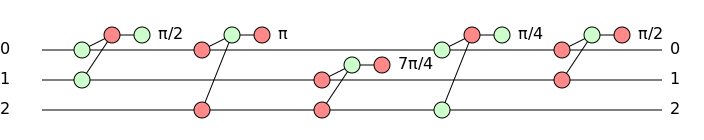

In [16]:
phase_circuit

The default colours for the Z and X basis are `#D8F8D8` and Burning Orange `#E8A6A6` respectively, the colours indicated in [the ZX calculus accessibility page](https://zxcalculus.com/accessibility.html) and tested using this [simulator](https://www.color-blindness.com/coblis-color-blindness-simulator/) for colour-vision deficiency. 
The default colours can be overridden with the `zcolor` and `xcolor` keyword arguments of the `to_svg` method:

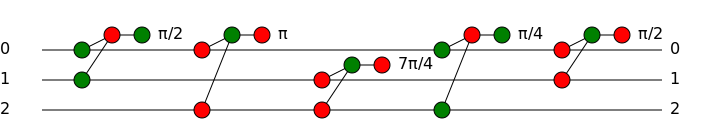

In [17]:
phase_circuit.to_svg(zcolor="green", xcolor="red")

The `to_svg` method also accepts keyword arguments `hscale` and `vscale` which can be used to scale the circuit horizontally and vertically:

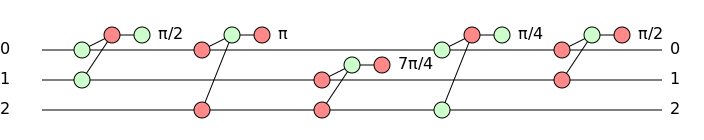

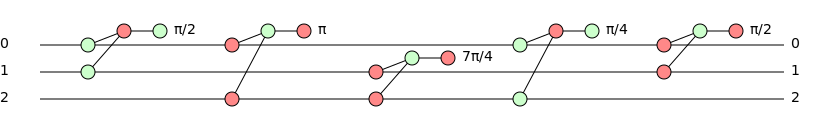

In [18]:
display(phase_circuit.to_svg())
display(phase_circuit.to_svg(hscale = 1.2, vscale=0.9))

## Random Circuits

The static method `PhaseCircuit.random(num_qubits, num_gadgets, **kwargs)` can be used to construct random circuits of mixed ZX phase gadgets. The allowed keyword arguments are:

- `angle_subdivision` which sets the denominator for random multiples of $\pi$ to be used as angles (default is 4, yielding 8 uniformly distributed angle values);
- `min_legs` which optionally sets the minimum number of legs for the phase gadgets (default is `None`, minimum is 1);
- `max_legs` which optionally sets the maximum number of legs for the phase gadgets (default is `None`, minimum is the value of `min_legs`);
- `rng_seed` which optionally sets the seed for the random number generator (default is `None`, for unseeded random number generator).

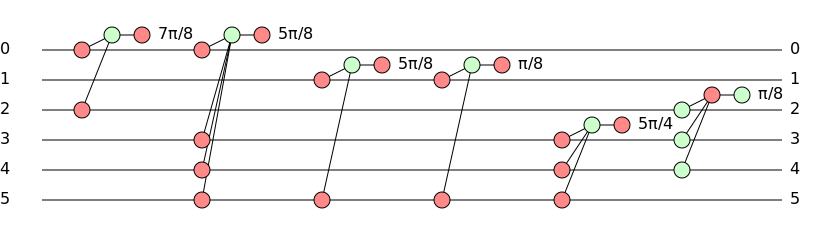

In [19]:
PhaseCircuit.random(6, 6, angle_subdivision=8,
                    min_legs=2, max_legs=4, rng_seed=5)

## Conjugation by CX Gates

The only operation that can be performed on mixed ZX phase gadget circuits is conjugation by a CX gate with given control and target. This is done through the method `PhaseCircuit.conj_by_cx(ctrl, trgt)`, which is unavailable on the read-only view.

Consider the following circuit with a single Z phase gadget:

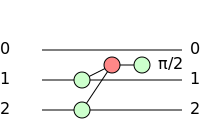

In [20]:
simple_circ = PhaseCircuit(3, [Z(pi/2) @ {1, 2}])
simple_circ

We conjugate the circuit with a CX gate $CX_{0, 1}$ having the qubit 0 as control and the qubit 1 as target. The circuit $\mathcal{C}$ is modified in-place, becoming $CX_{0, 1} \circ \mathcal{C} \circ CX_{0, 1}$.

In [21]:
svg_before = simple_circ.to_svg(svg_code_only=True)
simple_circ.conj_by_cx(0, 1)
svg_after = simple_circ.to_svg(svg_code_only=True)
side_by_side(svg_before, "<pre> ⎯⎯cx(0,1)⟶   </pre>", svg_after)

Multiple conjugations can be concatenated (see the [fluent interface pattern](https://en.wikipedia.org/wiki/Fluent_interface)).

In [22]:
svg_before = simple_circ.to_svg(svg_code_only=True)
simple_circ.conj_by_cx(0, 1).conj_by_cx(1, 2)
svg_after = simple_circ.to_svg(svg_code_only=True)
side_by_side(svg_before, "<pre> ⎯⎯cx(0,1)⎯⎯cx(1,2)⟶   </pre>", svg_after)

As a more complicated example, we conjugate `phase_circuit` from before by the same CX gate.

Original: 


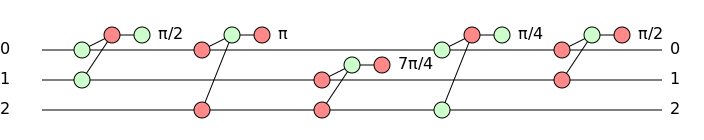

Conjugated by CX(0, 1): 


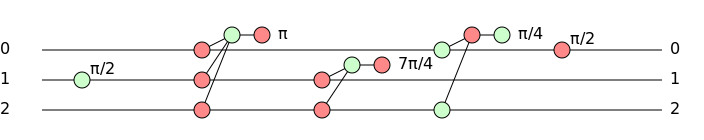

In [23]:
print("Original: "); display(phase_circuit)
phase_circuit.conj_by_cx(0, 1)
print("Conjugated by CX(0, 1): "); display(phase_circuit)

To avoid modification, a read-only view can be used in place of the actual circuit:

In [24]:
phase_circuit_view = phase_circuit.as_readonly
try:
    phase_circuit_view.conj_by_cx(0, 1)
except Exception as e:
    print("Exception:", e)

Exception: 'PhaseCircuitView' object has no attribute 'conj_by_cx'
